# Filtrage numérique

<hr>

## 📌 Commentaires pour les intervenants

* Les étudiants metttent du temps à faire ce TP...
  Donc : faire de nombreux points, mises en communs, interactions, évaluations, etc.
  Aussi : leur demander pourquoi c'est si long (en chronométrant le temps mis pour chaque question ?
  
* Laissez les étudiants chercher d'eux même comment sous-échantillonner un signal,
  et quelle précautions prendre (appliquer un filtre anti-repliement).
  Au bout d'un moment, poser la question et les aiguiller vers `scipy.signal.decimate`.
  
* Donner éventuellement les fonctions pour afficher le gain (`numpy.log10` et `abs`) et la phase (`numpy.angle`).

<hr>

Les fonctions de filtrage sont dans [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html).

In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import scipy.signal as signal

In [2]:
crii = "tab:green"
crif = "tab:purple"

## Affichage de l’ECG mesuré

Connaissant le nombre de points dans le signal (`numpy.shape`) et la fréquence d'échantillonnage, il est facile de générer un vecteur des abscisses pour tracer le signal en fonction du temps.

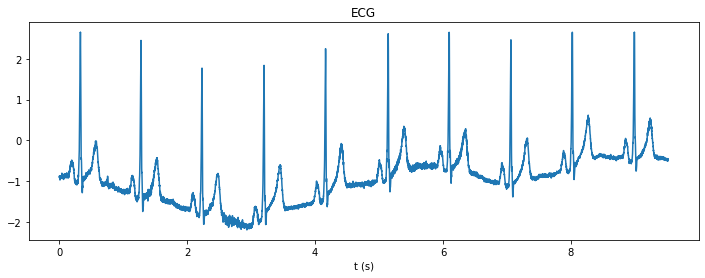

In [3]:
# Chargement du signal
x = np.loadtxt("../_static/ecg_lfn.csv")

# Abscisses
fe = 1000
N = len(x)
n = np.arange(N)
t = n/fe

# Affichage
plt.figure(figsize=(12,4))
plt.plot(t,x)
plt.xlabel("t (s)")
plt.title("ECG")
plt.show()

Attention : avant de sous-échantillonner, il convient d'appliquer un filtre anti-repliement !
On peut utiliser la fonction `scipy.signal.decimate`.

In [4]:
# scipy.signal.resample : sous ou sur-échantillonnage, avec la FFT
# scipy.signal.decimate : sous-échantillonnage après filtre anti-repliement (Chebyshev I ou fenêtre de Hamming)

In [5]:
x = signal.decimate(x, 10)

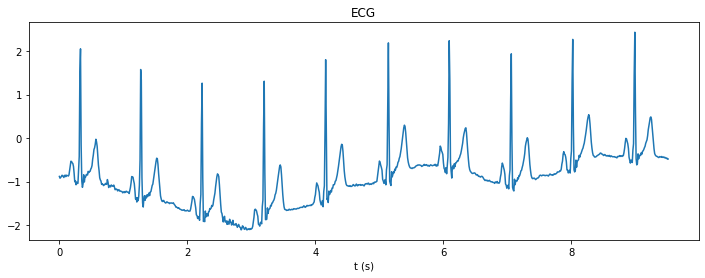

In [6]:
# Abscisses
fe = 100
N = len(x)
n = np.arange(N)
t = n/fe

# Affichage
plt.figure(figsize=(12,4))
plt.plot(t,x)
plt.xlabel("t (s)")
plt.title("ECG")
plt.show()

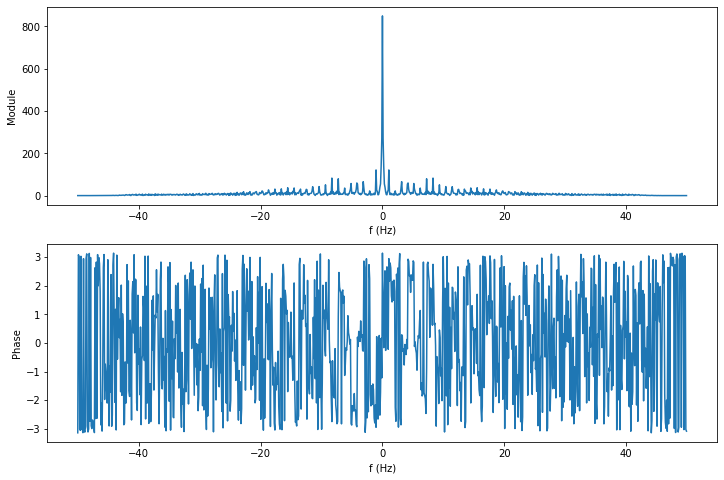

In [7]:
# Spectre
k = np.arange(-N/2, N/2)
f = k*fe/N

X = fft.fft(x)
X = fft.fftshift(X)

plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(f, abs(X))
plt.ylabel("Module")
plt.xlabel("f (Hz)")

plt.subplot(2,1,2)
plt.plot(f, np.angle(X))
plt.ylabel("Phase")
plt.xlabel("f (Hz)")

plt.show()

L'observation du spectre nous permet d'affirmer que le signal ECG est plutôt basse fréquence,
mais on le savait déjà en observant le signal temporel.
La phase n'est pas interprétable ; cela arrive souvent sur les signaux réels.

Finalement, le spectre ne nous permet pas, ici,
de déterminer les contenus fréquentiels de la variation basse fréquence d'une part, et des ondes d'autre part.

## Définition du gabarit

Or, on sait que les ondes apparaissent toutes les secondes environ (il y a dix ondes sur presque dix secondes) :
leur fréquence d'apparition est donc de l'ordre du hertz.
D'autre part, la variation basse fréquence peut être assimilée (très grossièrement) à un sinus de période sept secondes
(donc de fréquence 1/7 Hz).
Aussi, pour éliminer la composante basse fréquence, il faut réaliser un filtre passe-haut
dont la fréquence de coupure est comprise entre 1/7 Hz et 1 Hz.

Nous choisissons donc le gabarit représenté ci-dessous, avec une fréquence de la bande passante à 1 Hz, 
et une fréquence de la bande atténuée de 0,5 Hz.
Seule l'application sur le signal nous permettra d'affiner ces deux valeurs :
c'est pourquoi il est important de réaliser un code qui utilise des variables pour ces deux fréquences, afin de les changer facilement.

In [8]:
# Gabarit numérique
fmin, fmax = 0, fe/2
fp = 1
fs = 0.5
edB = 1
AdB = 60

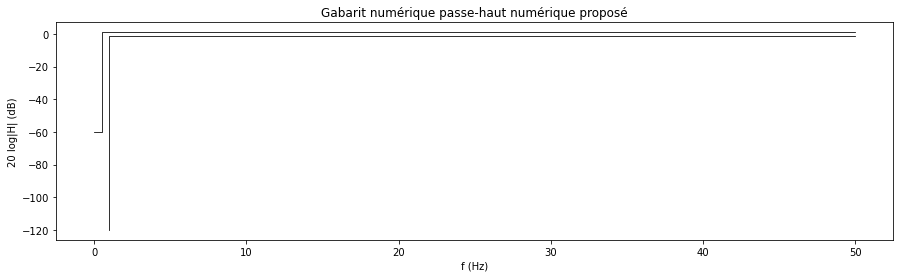

In [9]:
plt.figure(figsize=(15,4))
plt.plot( [fmin, fs, fs, fmax],[-AdB, -AdB, edB, edB], color='k', linewidth=.8)
plt.plot( [fp, fp, fmax],[-2*AdB, -edB, -edB], color='k', linewidth=.8)
plt.xlabel("f (Hz)")
plt.ylabel("20 log|H| (dB)")
plt.title("Gabarit numérique passe-haut numérique proposé")
plt.show()

In [10]:
# Affichage perso de la réponse d'un filtre

def rep(b, a, clr):
    
    # Nombre de points
    N = 2000
    
    # X Lim
    xl = [0, 5]
    
    # Réponse fréquentielle
    w, h = signal.freqz(b, a, worN=N, plot=None, fs=fe)
    
    fig, ((xmod, xgd), (xangle, xpz)) = plt.subplots(2, 2, figsize=(14,10))
    
    xmod.plot(w, 20*np.log10(abs(h)), clr)
    xmod.plot( [fmin, fs, fs, fmax],[-AdB, -AdB, edB, edB], color='k', linestyle='--', linewidth=.8)
    xmod.plot( [fp, fp, fmax],[-2*AdB, -edB, -edB], color='k', linestyle='--', linewidth=.8)
    xmod.set_ylabel("Module", fontsize=14)
    xmod.set_xlim(xl)
    xmod.set_ylim([-80, 10])
    xmod.set_xlabel("f (Hz)", fontsize=14)

    xangle.plot(w, np.angle(h), clr)
    xangle.set_xlim(xl)
    xangle.set_ylabel("Phase", fontsize=14)
    xangle.set_xlabel("f (Hz)", fontsize=14)
    
    # Retard de groupe
    w, gd = signal.group_delay((b,a), w=N, whole=False, fs=fe)
    
    xgd.plot(w, gd, clr)
    xgd.axvline(fp, color='k', linestyle='--', linewidth=.8)
    xgd.set_ylabel('Retard de groupe (échantillons)', fontsize=14)
    xgd.set_xlabel('f (Hz)', fontsize=14)
    xgd.set_xlim(xl)
    
    # Diagramme pôle-zéro
    z, p, k = signal.tf2zpk(b, a)
    
    xpz.plot(np.real(z), np.imag(z), "o", mfc='none', color=clr)
    xpz.plot(np.real(p), np.imag(p), "x", color=clr)
    theta = np.linspace(0, 2*np.pi, 50)
    xpz.plot(np.cos(theta), np.sin(theta), color="k", linewidth=.2)
    xpz.set_aspect(1)
    xpz.set_xlabel("Re(z)", fontsize=14)
    xpz.set_ylabel("Im(z)", fontsize=14)

    plt.show()
    
    return w#, h, gd, z, p, k

## Réalisation d'un filtre RIF avec la méthode des fenêtres

D'après le [tableau vu en cours](S:methode-des-fenetres),
pour respecter une atténuation de 60 dB, nous pouvons utiliser les fenêtres de Blackman ou Kaiser
(à la condition que $\beta$ soit suffisamment grand).

In [11]:
largeur_de_transition = (fp-fs) / fe

In [12]:
print("Ordre des fenêtres (déterminé à partir de la largeur de transition) :")
print(f"Blackman :             N = {int(5.5/largeur_de_transition)}")
print(f"Kaiser (beta = 6,76) : N = {int(4.32/largeur_de_transition)}")
print(f"Kaiser (beta = 8,96) : N = {int(5.71/largeur_de_transition)}")

Ordre des fenêtres (déterminé à partir de la largeur de transition) :
Blackman :             N = 1100
Kaiser (beta = 6,76) : N = 864
Kaiser (beta = 8,96) : N = 1142


La fenêtre de Kaiser avec $\beta=6,76$ est la fenêtre qui donne l'ordre le plus faible : c'est donc celle-ci qu'on choisit.

En pratique, l'ordre donné par la méthode des fenêtres est souvent trop grand.
Je choisis donc un ordre plus faible.

Ordre du filtre RIF : 801


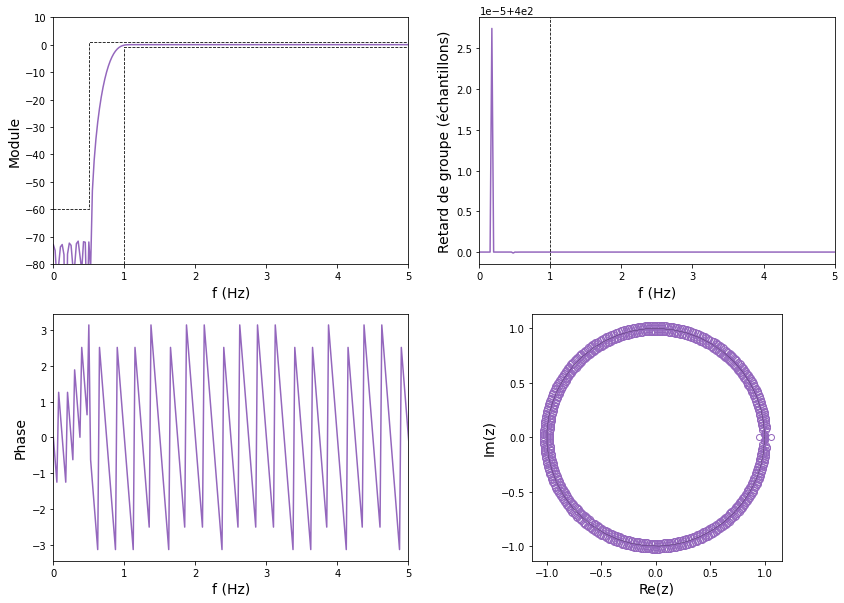

In [13]:
N = 801
b_rif = signal.firwin(numtaps=N, cutoff=0.8, width=None, window=("kaiser", 6.76), pass_zero="highpass", scale=True, fs=fe)

print(f"Ordre du filtre RIF : {len(b_rif)}")
rif = rep(b_rif, 1, crif)

Le filtre RIF synthétisé respecte bien le gabarit et ne génère aucune oscillation dans la bande passante.
La phase est linéaire, et donc le retard de groupe est constant.
Les deux pics visibles sur le retard de groupe sont probablement dus à des erreurs numériques.
Enfin, le filtre étant d'ordre très élevé, il existe énormément de zéros, qui sont visibles sur le diagramme pôles-zéros.
Le filtre RIF est toujours stable, aucun pôle n'existe.

In [14]:
# Quel est le gain à la fréquence donnée en argument ?

N = 41
b_tmp = signal.firwin(numtaps=N, cutoff=0.8, width=None, window=("kaiser", 6.76), pass_zero="highpass", scale=True, fs=fe)

w = np.arange(.5,1.1,.1)
w, h = signal.freqz(b_tmp, 1, worN=w, plot=None, fs=fe)

for i in range(len(w)):
    print(f"{w[i]:.1f} Hz  :  {20*np.log10(np.abs(h[i])):.3f}")

0.5 Hz  :  -2.963
0.6 Hz  :  -2.926
0.7 Hz  :  -2.882
0.8 Hz  :  -2.833
0.9 Hz  :  -2.778
1.0 Hz  :  -2.718
1.1 Hz  :  -2.653


## Réalisation d'un filtre RII avec la transformation bilinéaire

Le gabarit analogique est le même que le gabarit numérique, à l'exception des fréquences qui sont calculées à partir de l'expression

$$
f_a = \frac{f_e}{\pi} \tan\left(\pi\frac{f_n}{f_e}\right).
$$

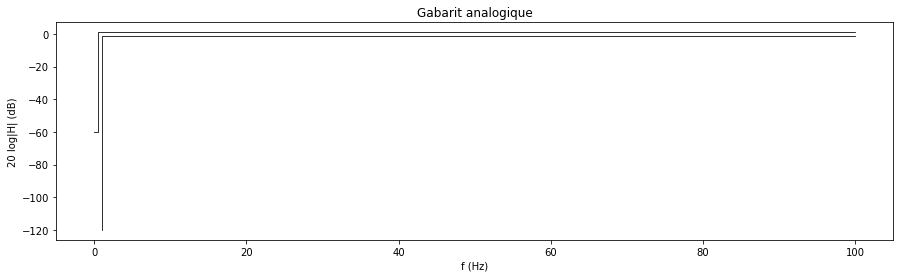

In [15]:
def fn2fa(fn, fe):
    return fe/np.pi * np.tan( np.pi*fn/fe )

fsa = fn2fa(fs, fe)
fpa = fn2fa(fp, fe)
fmax = 100

plt.figure(figsize=(15,4))
plt.plot( [fmin, fsa, fsa, fmax],[-AdB, -AdB, edB, edB], color='k', linewidth=.8)
plt.plot( [fpa, fpa, fmax],[-2*AdB, -edB, -edB], color='k', linewidth=.8)
plt.xlabel("f (Hz)")
plt.ylabel("20 log|H| (dB)")
plt.title("Gabarit analogique")
plt.show()

L'expression de la transformation bilinéaire permettant d'obtenir H(z) à partir de H(s) est :

$$
H_n(z) = H_a\left(2f_e \left(\frac{1-z^{-1}}{1+z^{-1}}\right)\right).
$$

Cela dit, les formules précédentes ne sont pas nécessaires pour la synthèse du filtre RII puisque la fonction `iirdesign` effectue le schéma complet de la transformation bilinéaire :
détermination du gabarit analogique, synthèse du filtre analogique, et enfin transformation de la fonction de transfert analogique en fonction de transfert numérique.

La fonction utilise `ordfunc` et `iirfilter` puis la transformée bilinéaire `bilinear_zpk`.

Ordre du filtre RII : 6


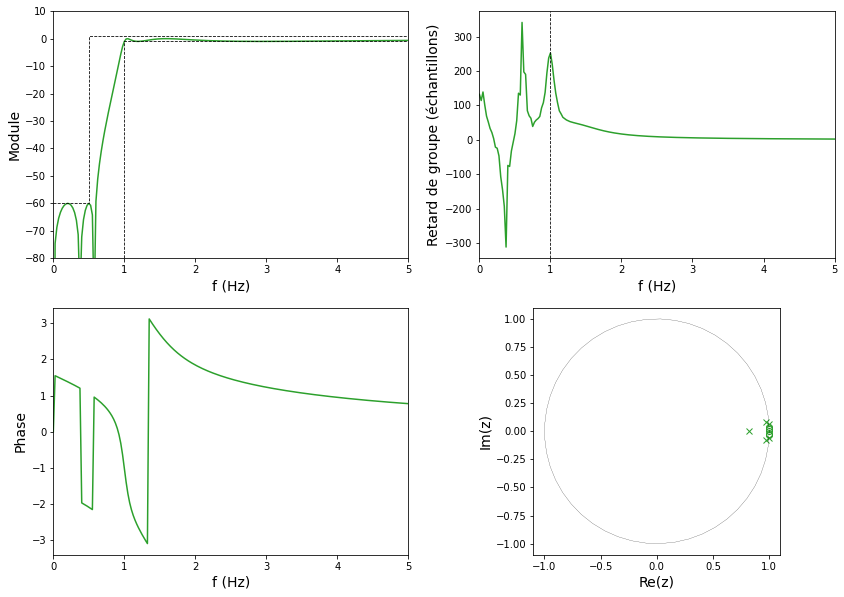

In [16]:
b_rii, a_rii = signal.iirdesign(wp=fp, ws=fs, gpass=edB, gstop=AdB, analog=False, ftype='ellip', output='ba', fs=fe)

print(f"Ordre du filtre RII : {len(b_rii)}")

rii = rep(b_rii, a_rii, crii)

Le filtre RII synthétisé respecte bien le gabarit, quelques oscillations sont visibles dans la bande passante.
La phase évolue doucement mais présentent plusieurs « sauts ».
Les premiers sauts de phase ont une valeur de $\pi$ et correspondent à une inversion de signe dans la réponse fréquentielle et se traduisent par un rebond sur le module.
Le dernier saut de phase a une valeur de $2\pi$ et ne traduit aucun phénomène : ce saut existe seulement parce que la phase est ici représentée entre $-\pi$ et $\pi$.
Comme la phase n'est pas linéaire, le retard de groupe n'est pas constant.
Enfin, le diagramme pôles-zéros fait apparaître des pôles qui sont tous dans le cercle unité : le filtre est donc stable.

## Réalisation du filtre RIF avec la méthode de Parks-McClellan

En général, la méthode de Parks-McClellan es très intéressante et fournit des filtres RIF d'ordre moins élevés que ceux produits avec la méthode des fenêtres.
Mais dans notre cas, cette méthode ne donne pas de résultat satisfaisant (le gabarit n'est pas du tout respecté) car la bande de transition est très faible et très à gauche dans les fréquences.

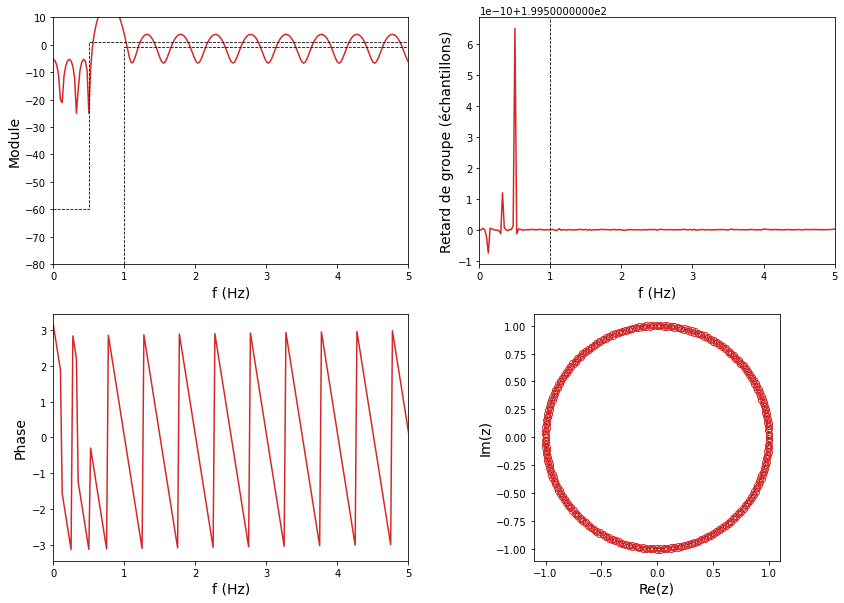

In [17]:
# def plot_response(fs, w, h, title):
#     "Utility function to plot response functions"
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
#     ax.set_ylim(-40, 5)
#     ax.set_xlim(0, 0.5*fs)
#     ax.grid(True)
#     ax.set_xlabel('Frequency (Hz)')
#     ax.set_ylabel('Gain (dB)')
#     ax.set_title(title)
    
numtaps = 400
taps = signal.remez(numtaps, [0, fs, fp, 0.5*fe], [0, 1], fs=fe, maxiter=50)
pm = rep(taps, 1, "tab:red")

## Réalisation d'un filtre idéal

Comme le signal ECG est enregistré, on peut y appliquer un filtre idéal en travaillant dans le domaine de Fourier.
Pour cela, on multiplie le spectre du signal par une réponse fréquentielle nulle pour les fréquences inférieures à la fréquence de coupure, et égale à 1 au delà.

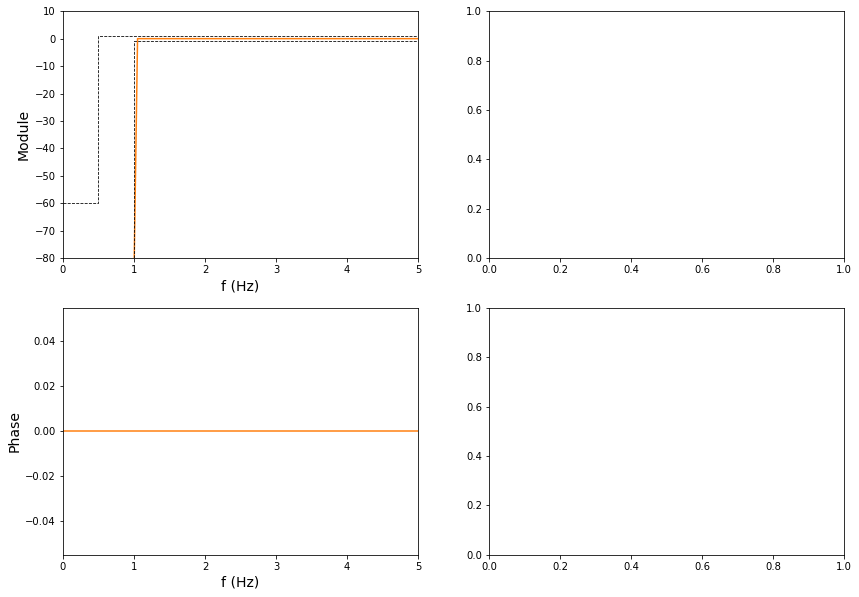

In [18]:
# Réponse fréquentielle idéale
Nx = len(X)
k = np.arange(-Nx/2, Nx/2)
f = k*fe/Nx
H = (np.abs(f)>fp)*1

# Filtrage
Y = X*H
yid = np.real(fft.ifft(fft.ifftshift(Y)))
    
# X Lim
xl = [0, 5]
    
# Réponse fréquentielle
clr = "tab:orange"
fig, ((xmod, xgd), (xangle, xpz)) = plt.subplots(2, 2, figsize=(14,10))
    
xmod.plot(f, 20*np.log10(abs(H)+1e-9), clr)
xmod.plot( [fmin, fs, fs, fmax],[-AdB, -AdB, edB, edB], color='k', linestyle='--', linewidth=.8)
xmod.plot( [fp, fp, fmax],[-2*AdB, -edB, -edB], color='k', linestyle='--', linewidth=.8)
xmod.set_ylabel("Module", fontsize=14)
xmod.set_xlim(xl)
xmod.set_ylim([-80, 10])
xmod.set_xlabel("f (Hz)", fontsize=14)

xangle.plot(f, np.angle(H), clr)
xangle.set_xlim(xl)
xangle.set_ylabel("Phase", fontsize=14)
xangle.set_xlabel("f (Hz)", fontsize=14)

plt.show()

Le module du filtre idéal correspond bien à une porte.
Dans la représentation ci-dessous, la porte n'est visible que pour des fréquences supérieures à la fréquence de coupure car le module est tracé en échelle logarithmique, donc les amplitudes nulles de la réponse fréquentielle sont renvoyées en $-\infty$.
La phase est linéaire et même constante ; on ne représente pas le retard de groupe qui serait nul.
Enfin, le filtre n'ayant pas d'expression sous forme de fonction de transfert, on ne peut pas définir des pôles et des zéros et on ne peut donc pas représenter son diagramme pôles-zéros.

## Application

Nous représentons ci-dessous le signal temporel et son spectre du signal ECG original et des sorties des filtres (RIF, RII et idéal).

On observe que le filtre RIF donne un signal filtré plus « propre » (d'un point de vue médical) que le filtre RII.
Le filtre idéal est quant à lui encore meilleur.
Cela s'explique par le fait qu'il ne génère aucune oscillation, ni en bande atténuée ni en bande passante,
et que par ailleurs le signal basse fréquence de l'ECG est spectralement très différent du signal d'intérêt : on peut donc les séparer proprement par filtrage des fréquences.

Enfin, on peut également observer le retard de groupe important sur le filtre RIF.

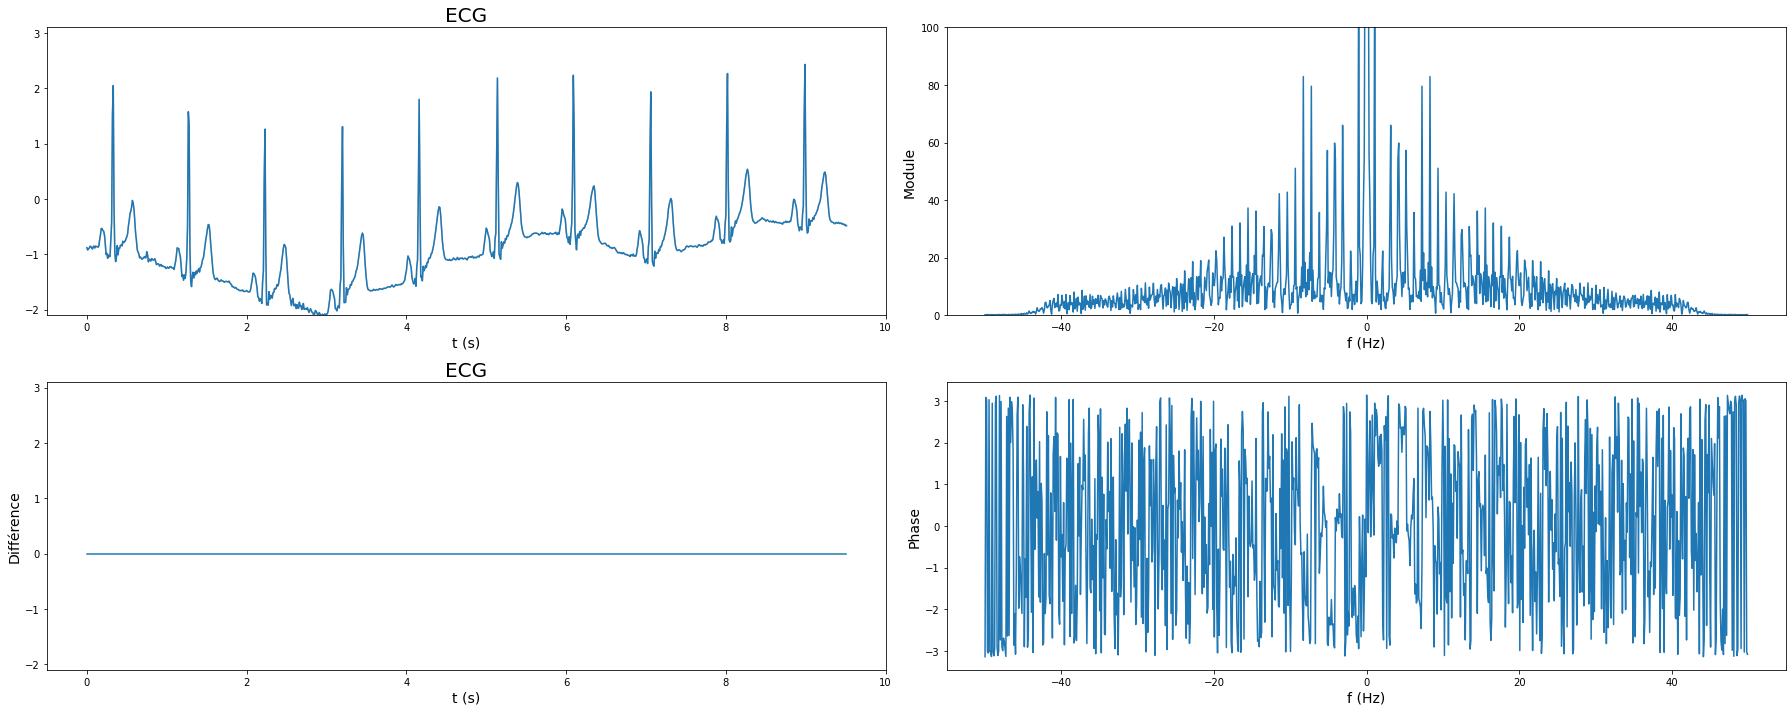

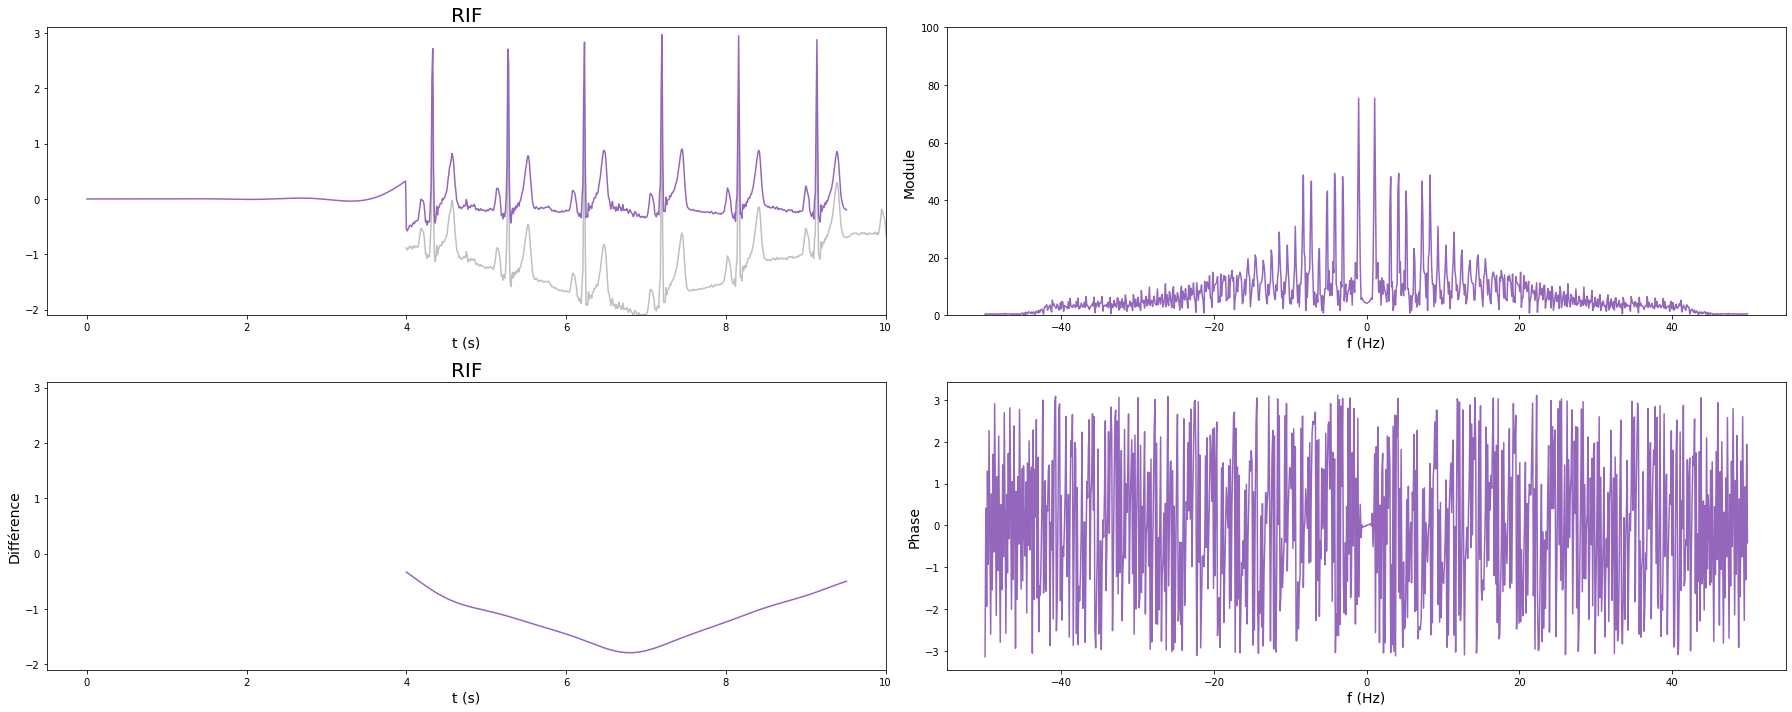

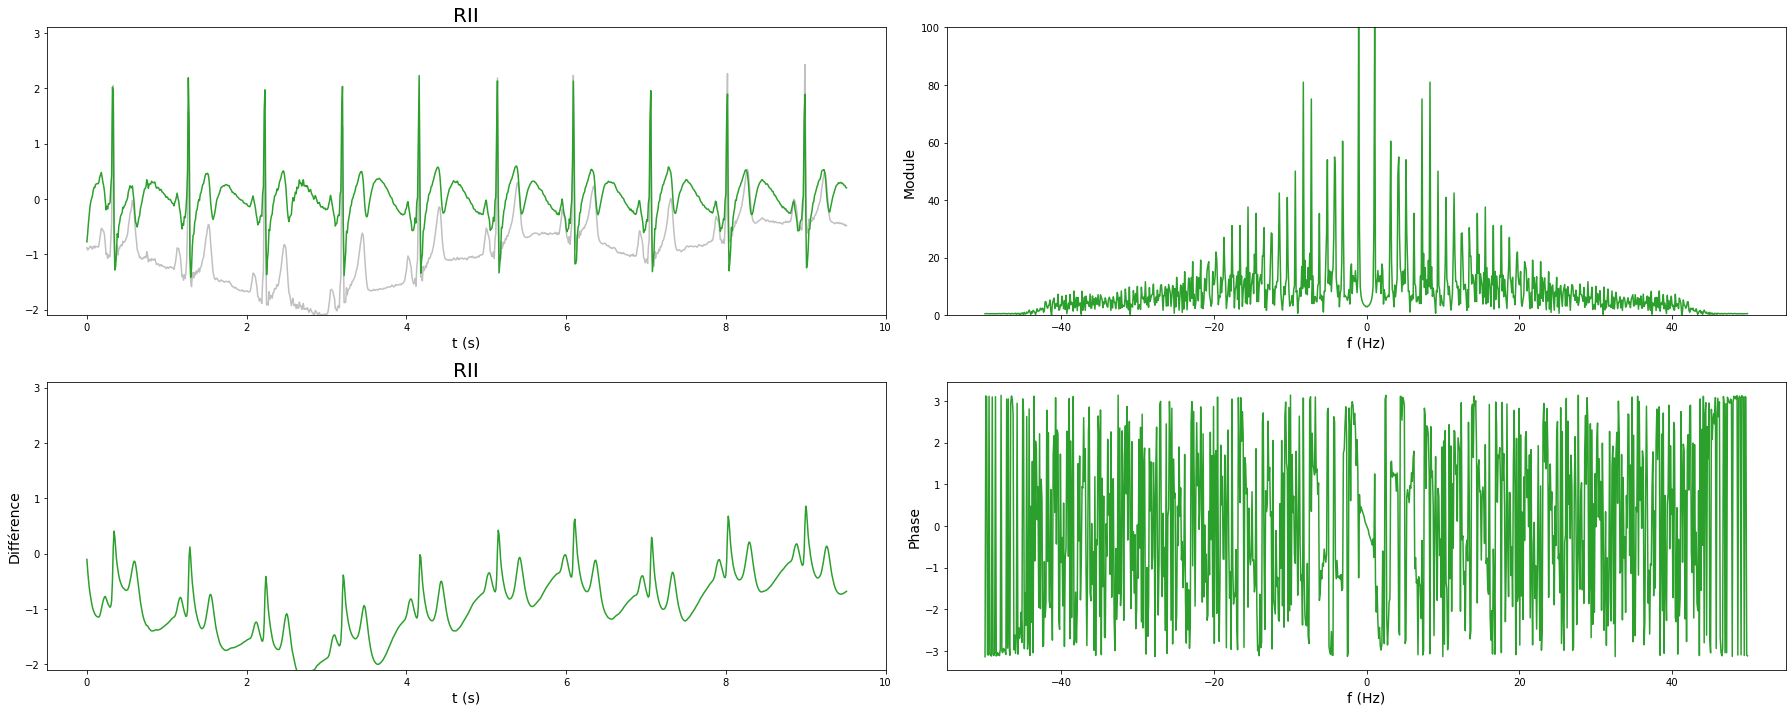

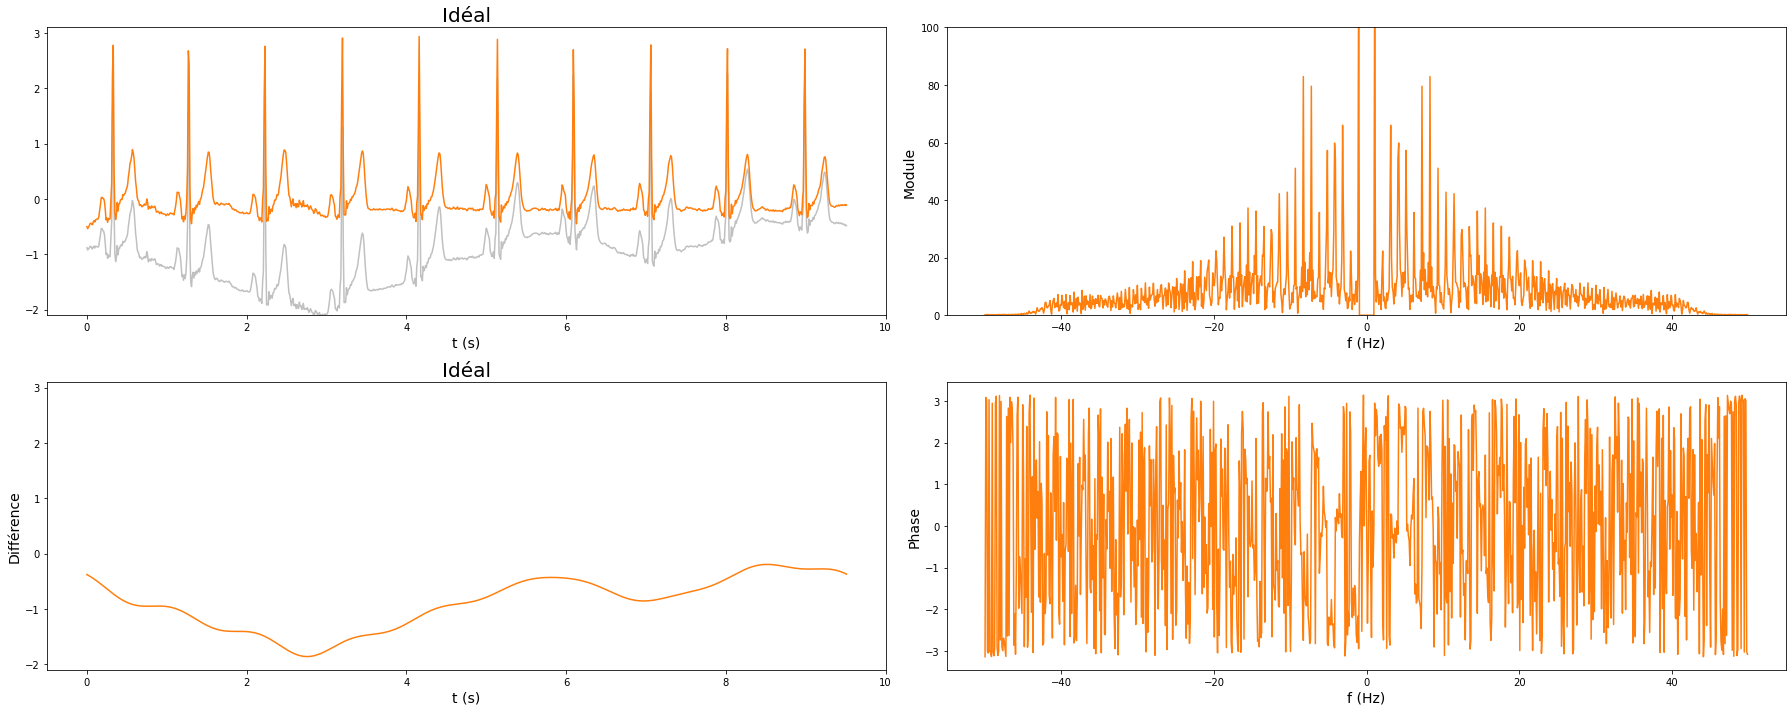

In [19]:
yrii = signal.lfilter(b_rii,a_rii,x)
yrif = signal.lfilter(b_rif,1,x)
N = len(x)

signaux = [
    ["ECG",   x,     "tab:blue",   0 ],
    ["RIF",   yrif,  crif,         4 ],
    ["RII",   yrii,  crii,         0 ],
    ["Idéal", yid,   "tab:orange", 0 ],
]

for sig in signaux:
    
    plt.figure(figsize=(25,10))
    
    _, s, clr, dec = sig

    plt.subplot(2,2,1)
    plt.plot(t+dec, x, "#c0c0c0")
    plt.plot(t, s, clr)
    plt.xlabel("t (s)", fontsize=14)
    plt.title(sig[0], fontsize=20)
    plt.xlim([-.5, 10])
    plt.ylim([-2.1, 3.1])

    plt.subplot(2,2,3)
    L = dec*fe
    plt.plot(t[L:], x[:N-L]-s[L:], clr)
    plt.ylabel("Différence", fontsize=14)
    plt.xlabel("t (s)", fontsize=14)
    plt.title(sig[0], fontsize=20)
    plt.xlim([-.5, 10])
    plt.ylim([-2.1, 3.1])
    
    S = fft.fft(s)
    S = fft.fftshift(S)
    N = len(S)
    k = np.arange(-N/2, N/2)
    f = k*fe/N

    plt.subplot(2,2,2)
    plt.plot(f, abs(S), clr)
    plt.ylabel("Module", fontsize=14)
    plt.xlabel("f (Hz)", fontsize=14)
    plt.ylim([0, 100])
    
    plt.subplot(2,2,4)
    plt.plot(f, np.angle(S), clr)
    plt.ylabel("Phase", fontsize=14)
    plt.xlabel("f (Hz)", fontsize=14)

    plt.tight_layout()
    plt.show()

## Effet de la quantification des coefficients

En se concentrant sur les deux filtres à réaliser dans ce TP (le filtre RIF et le filtre RII), on constate que la précision des coefficients est importantes.
Dans les figures ci-dessous, on a représenté le gain de la réponse fréquentielle des deux filtres en n'utilisant que certains chiffres décimaux des coefficients : une troncature est donc effectuée.
On constate que le filtre RIF est plus stable à cette troncature car il respecte le gabarit même si peu de chiffres sont conservés.
Cela indique donc que la mémoire utilisée par chaque coefficient peut être moindre avec un filtre RIF qu'avec un filtre RII.
Mais ce gain possible en mémoire est contrebalancé par le fait que le filtre RIF nécessite beaucoup plus de coefficients que le filtre RII.

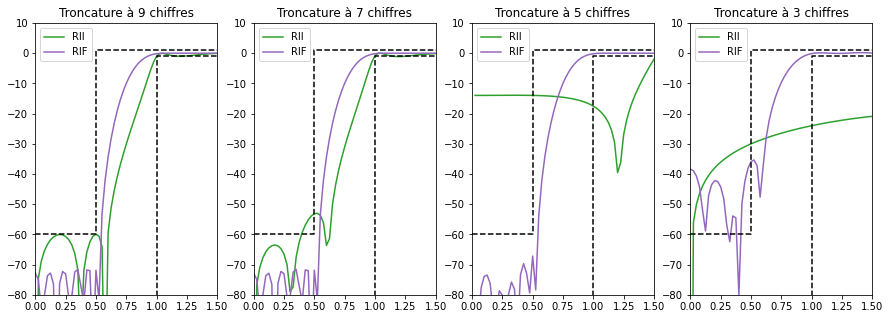

In [20]:
np.seterr(divide='ignore', invalid='ignore')

r = range(9, 1, -2)
N = len(r)
fig, axs = plt.subplots(1, N, figsize=(15,5))

for n in range(N):
    
    # Troncature
    b_rii_rounded = np.around(b_rii, r[n])
    a_rii_rounded = np.around(a_rii, r[n])
    b_rif_rounded = np.around(b_rif, r[n])
    
    # Réponses fréquentielles
    w, h_rii = signal.freqz(b_rii_rounded, a_rii_rounded, worN=2000, plot=None, fs=fe)
    w, h_rif = signal.freqz(b_rif_rounded, 1,             worN=2000, plot=None, fs=fe)
    
    # Affichage
    axs[n].plot(w, 20*np.log10(abs(h_rii)), color=crii, label="RII")
    axs[n].plot(w, 20*np.log10(abs(h_rif)), color=crif, label="RIF")
    axs[n].plot( [fmin, fs, fs, fmax],[-AdB, -AdB, edB, edB], "k--");
    axs[n].plot( [fp, fp, fmax],[-2*AdB, -edB, -edB], "k--");
    axs[n].set_xlim([0, 1.5])
    axs[n].set_ylim([-80, 10])
    axs[n].legend()
    axs[n].set_title(f"Troncature à {r[n]} chiffres")

### Avantages

**RII** :
- déphaseurs réalisables
- complexité faible par rapport à un RIF

**RIF** :
- toujours stables
- phase linéaire possible
- robuste par rapport à la troncature


### Inconvénients

**RII** :
- pas toujours stables

**RIF** :
- complexité (proportionnelle à la longueur de la réponse impulsionnelle) plus grande qu'un RII
- charge de calcul supérieure aux RII


### Méthodes de synthèse

**RII** :
- à partir des filtres analogiques : invariance (de la réponse impulsionnelle ou autre), transformation bilinéaire
- calcul direct des coefficients
- procédure itérative d'optimisation
- Butterworth généralisée

**RIF** :
- fenêtres (la plus élémentaire) → toutes les fenêtres ne se valent pas (coupent plus ou moins, sont plus ou moins compliquées)
- moindres carrés
- valeurs propres
- méthode itérative (Chebychev, Remez)
- maximalement plats
- filtres périodiques